In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import re

In [2]:
#df = pd.read_csv('../input/train.csv')
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Fill missing fields with columns means
df = df.fillna(df.mean())
df['Cabin'] = df['Cabin'].fillna('U')
df = df.fillna('N/A')

# Fill missing fields with columns means
df_test = df_test.fillna(df_test.mean())
df_test['Cabin'] = df_test['Cabin'].fillna('U')
df_test = df_test.fillna('N/A')

print(df[ ['Name', 'Survived'] ])
#print(df_test.head())

print(df.describe())
print(df.dtypes)


# Transforming cabin code to a deck, adding 'U' (unknown) for the missing ones
df['Deck'] = pd.Series([re.split('(\d.*)',s)[0][0] for s in df['Cabin']])
df_test['Deck'] = pd.Series([re.split('(\d.*)',s)[0][0] for s in df_test['Cabin']])

print(df['Deck'].unique())
print(df_test['Deck'].unique())



                                                  Name  Survived
0                              Braund, Mr. Owen Harris         0
1    Cumings, Mrs. John Bradley (Florence Briggs Th...         1
2                               Heikkinen, Miss. Laina         1
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)         1
4                             Allen, Mr. William Henry         0
5                                     Moran, Mr. James         0
6                              McCarthy, Mr. Timothy J         0
7                       Palsson, Master. Gosta Leonard         0
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)         1
9                  Nasser, Mrs. Nicholas (Adele Achem)         1
10                     Sandstrom, Miss. Marguerite Rut         1
11                            Bonnell, Miss. Elizabeth         1
12                      Saundercock, Mr. William Henry         0
13                         Andersson, Mr. Anders Johan         0
14                Vestrom

# Labeling

In [3]:
labels = ['Sex', 'Embarked', 'Deck']
les = {}

for l in labels:
    print('labeling ' + l)
    les[l] = LabelEncoder()
    les[l].fit(df[l])
    tr = les[l].transform(df[l]) 
    df.loc[:, l + '_feat'] = pd.Series(tr, index=df.index)

    tr_test = les[l].transform(df_test[l]) 
    df_test.loc[:, l + '_feat'] = pd.Series(tr_test, index=df_test.index)


# le.classes_
#print(df.head())

labeling Sex
labeling Embarked
labeling Deck


## Adding new features

Here I try to add some more features in order to take the most from this small dataset

In [4]:
# Under-18 feature
df['U18'] = df['Age'] < 18
df_test['U18'] = df_test['Age'] < 18

# Lady with child
df['lwc'] = (df['Age'] > 18 ) & (df['Age'] <= 35 ) & (df['Parch'] > 0)
df_test['lwc'] = (df_test['Age'] > 18 ) & (df_test['Age'] <= 35 ) & (df_test['Parch'] > 0)

df['NameLen'] = [len(n) for n in df['Name']]
df_test['NameLen'] = [len(n) for n in df_test['Name']]


## Preparing datasets

In [5]:
X_train = df.drop(labels, 1) \
    .drop('Survived', 1) \
    .drop('Cabin', 1) \
    .drop('Ticket', 1) \
    .drop('Name', 1) \
    .drop('PassengerId', 1)
y_train = df['Survived']

X_test = df_test.drop(labels, 1) \
    .drop('Cabin', 1) \
    .drop('Ticket', 1) \
    .drop('Name', 1) \
    .drop('PassengerId', 1)

print("X_train shape", X_train.shape)
print("X_test  shape", X_test.shape)


X_train shape (891, 11)
X_test  shape (418, 11)


## Some visualizations

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


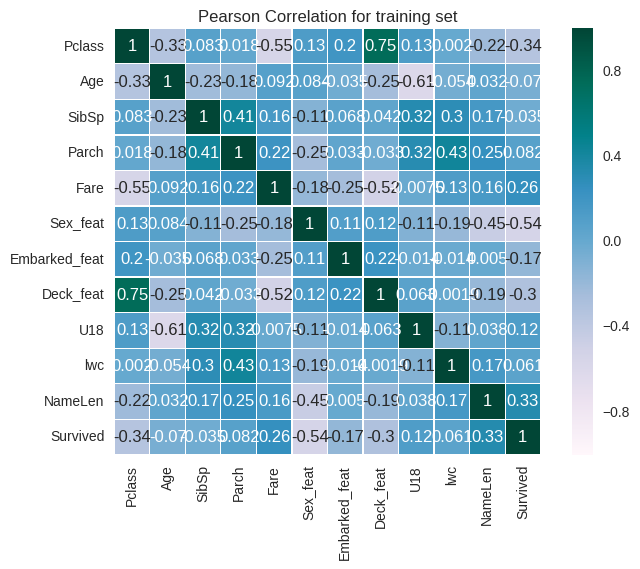

In [6]:
import seaborn as sns

full_set = X_train[:]
full_set['Survived'] = y_train

plt.title('Pearson Correlation for training set')
sns.heatmap(full_set.astype(float).corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            cmap="PuBuGn", 
            linecolor='w', 
            annot=True)


TODO: I'll try to remove Age, SibSp and Parch from the training set because they seem to be very less related to the Survival than the other features

# Training some models

I split the set in a training set and a validation set in order to check the algorithm score once trained

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import math

X_tr, X_ts, y_tr, y_ts = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
print(X_tr.shape, y_tr.shape, X_ts.shape, y_ts.shape)


(596, 11) (596,) (295, 11) (295,)


#### Decision tree

In [8]:
tree = DecisionTreeClassifier()
tree.fit(X_tr, y_tr)

pred = tree.predict(X_ts)

err = math.sqrt(((pred - y_ts)**2).mean())
print("Error: %.3f" % err)


Error: 0.480


The decision tree seems to overfit the dataset

In [9]:
# Training the validated model with the whole training set
tree.fit(X_train, y_train)

print(X_tr.shape)
print(X_test.shape)
pred = tree.predict(X_test)

df_test['Survived'] = pd.Series(pred)
sub = df_test[['PassengerId','Survived']]

sub.to_csv('submission_tree.csv', index=False)


(596, 11)
(418, 11)


#### Logistic regression

Error: 0.484 Score: 0.766


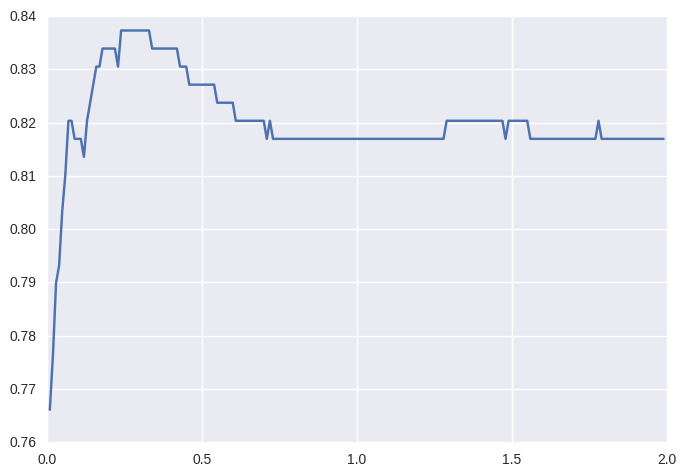

In [10]:
cs = np.arange(.01, 2.0, .01)
results = []
for C in cs:
#    print("Calculated for C = ", C)
    results.append(LogisticRegression(C = C).fit(X_tr, y_tr).score(X_ts, y_ts))

    
plt.plot(cs, results)

C = 0.01
logistic = LogisticRegression(C = C)
logistic.fit(X_tr, y_tr)
pred = logistic.predict(X_ts)

score = logistic.score(X_ts, y_ts)
err = math.sqrt(((pred - y_ts)**2).mean())

print("Error: %.3f Score: %.3f" % (err, score))


In [11]:
# Training the validated model with the whole training set
logistic.fit(X_train, y_train)

print(X_tr.shape)
print(X_test.shape)
pred = logistic.predict(X_test)

df_test['Survived'] = pd.Series(pred)
sub = df_test[['PassengerId','Survived']]

sub.to_csv('submission_logistic.csv', index=False)


(596, 11)
(418, 11)


#### SVC with linear kernel

In [12]:
from sklearn import svm

#cs = np.arange(.2, 2, .2)
#results = []
#for c in cs:
    #print("Calculated for c = ", c)
#    results.append(svm.SVC(kernel='linear', C=c).fit(X_tr, y_tr).score(X_ts, y_ts))

#plt.plot(cs, results)

C = 1.0
svc = svm.SVC(kernel='linear', C=C)
svc.fit(X_tr, y_tr)

pred = svc.predict(X_ts)

score = svc.score(X_ts, y_ts)
err = math.sqrt(((pred - y_ts)**2).mean())

print("Error: %.3f Score: %.3f" % (err, score))

Error: 0.451 Score: 0.797


In [13]:
# Training the validated model with the whole training set
svc.fit(X_train, y_train)

print(X_tr.shape)
print(X_test.shape)
pred = svc.predict(X_test)

df_test['Survived'] = pd.Series(pred)
sub = df_test[['PassengerId','Survived']]

sub.to_csv('submission_svc.csv', index=False)


(596, 11)
(418, 11)


#### Random forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=50)
forest.fit(X_tr, y_tr)

pred = forest.predict(X_ts)

score = forest.score(X_ts, y_ts)
err = math.sqrt(((pred - y_ts)**2).mean())

print("Error: %.3f Score: %.3f" % (err, score))

Error: 0.428 Score: 0.817


In [28]:
# Training the validated model with the whole training set
forest.fit(X_train, y_train)

print(X_tr.shape)
print(X_test.shape)
pred = forest.predict(X_test)

df_test['Survived'] = pd.Series(pred)
sub = df_test[['PassengerId','Survived']]

sub.to_csv('submission_forest.csv', index=False)


(596, 11)
(418, 11)
